In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [26]:
df = pd.read_csv("data/stud.csv")

We won't use the dataset with the `total_score` and `average` columns we created in EDA step because this were computed with using our target variable, this will force the model to learn genuine relationships (e.g., from demographic information or other exam scores that are not direct functions of writing_score). This results in **data leakage**, where the model has access to information that makes the prediction trivial.

In [27]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Prepare Data

In [28]:
X = df.drop(columns=["writing_score"], axis=1)
y = df["writing_score"]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race_ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [30]:
# Build a pipeline to preprocess the data
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

num_transformer = StandardScaler()
ohe_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", ohe_transformer, cat_features),
        ("StandardScaler", num_transformer, num_features),        
    ]
)

In [31]:
X = preprocessor.fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Train set shape: (800, 19), Test set shape: (200, 19)


In [33]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [34]:
# Models to be evaluated.
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

# Scoring metrics for cross validation.
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Number of folds for cross validation.
cv_folds = 5

# Container for all the results.
results = []

for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    
    # Perform cross validation on the training set.
    cv_results = cross_validate(
        model, X_train, y_train, cv=cv_folds, scoring=scoring, return_train_score=True
    )
    
    # Average metrics across folds for training and validation sets.
    train_mae = -np.mean(cv_results['train_MAE'])
    train_rmse = np.sqrt(-np.mean(cv_results['train_MSE']))
    train_r2 = np.mean(cv_results['train_R2'])
    
    valid_mae = -np.mean(cv_results['test_MAE'])
    valid_rmse = np.sqrt(-np.mean(cv_results['test_MSE']))
    valid_r2 = np.mean(cv_results['test_R2'])
    
    print("Cross-Validation Performance on Training Folds:")
    print(f"Mean Absolute Error: {train_mae:.4f}")
    print(f"Root Mean Squared Error: {train_rmse:.4f}")
    print(f"R2 Score: {train_r2:.4f}")
    
    print("Cross-Validation Performance on Validation Folds:")
    print(f"Mean Absolute Error: {valid_mae:.4f}")
    print(f"Root Mean Squared Error: {valid_rmse:.4f}")
    print(f"R2 Score: {valid_r2:.4f}")
    
    # Fit the model on the entire training set and evaluate on the test set.
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)
    
    print("Final Evaluation on Test Set:")
    print(f"Mean Absolute Error: {test_mae:.4f}")
    print(f"Root Mean Squared Error: {test_rmse:.4f}")
    print(f"R2 Score: {test_r2:.4f}")
    print("="*50, "\n")
    
    # Store results in a dictionary.
    results.append({
        "Model": model_name,
        "Train MAE": train_mae,
        "Train RMSE": train_rmse,
        "Train R2": train_r2,
        "CV Valid MAE": valid_mae,
        "CV Valid RMSE": valid_rmse,
        "CV Valid R2": valid_r2,
        "Test MAE": test_mae,
        "Test RMSE": test_rmse,
        "Test R2": test_r2
    })

Evaluating model: Linear Regression
Cross-Validation Performance on Training Folds:
Mean Absolute Error: 2.7051
Root Mean Squared Error: 3.3658
R2 Score: 0.9501
Cross-Validation Performance on Validation Folds:
Mean Absolute Error: 2.7624
Root Mean Squared Error: 3.4466
R2 Score: 0.9468
Final Evaluation on Test Set:
Mean Absolute Error: 3.2003
Root Mean Squared Error: 3.8615
R2 Score: 0.9381

Evaluating model: Lasso
Cross-Validation Performance on Training Folds:
Mean Absolute Error: 3.6463
Root Mean Squared Error: 4.5114
R2 Score: 0.9103
Cross-Validation Performance on Validation Folds:
Mean Absolute Error: 3.6659
Root Mean Squared Error: 4.5355
R2 Score: 0.9082
Final Evaluation on Test Set:
Mean Absolute Error: 3.8964
Root Mean Squared Error: 4.9256
R2 Score: 0.8993

Evaluating model: Ridge
Cross-Validation Performance on Training Folds:
Mean Absolute Error: 2.7055
Root Mean Squared Error: 3.3659
R2 Score: 0.9501
Cross-Validation Performance on Validation Folds:
Mean Absolute Error: 

In [35]:
# Create a DataFrame to display the results.
results_df = pd.DataFrame(results, 
                          columns=[
                              "Model",
                              "Train MAE",
                              "Train RMSE",
                              "Train R2",
                              "CV Valid MAE",
                              "CV Valid RMSE",
                              "CV Valid R2",
                              "Test MAE",
                              "Test RMSE",
                              "Test R2"
                              ]
                          ).round(4).set_index("Model").sort_values(ascending=False, by="Test R2")
results_df

,Train MAE,Train RMSE,Train R2,CV Valid MAE,CV Valid RMSE,CV Valid R2,Test MAE,Test RMSE,Test R2
Model,,,,,,,,,
Linear Regression,2.7051,3.3658,0.9501,2.7624,3.4466,0.9468,3.2003,3.8615,0.9381
Ridge,2.7055,3.3659,0.9501,2.7625,3.4461,0.9468,3.2005,3.8612,0.9381
Random Forest Regressor,1.2143,1.5127,0.9899,3.2507,4.0200,0.9280,3.6118,4.4750,0.9169
CatBoosting Regressor,1.2730,1.6331,0.9883,2.9895,3.7541,0.9372,3.4961,4.4781,0.9168
XGBRegressor,0.2240,0.3760,0.9994,3.4100,4.2267,0.9203,3.5653,4.5139,0.9155
AdaBoost Regressor,3.3395,4.0071,0.9293,3.5448,4.3706,0.9152,3.7408,4.6632,0.9098
Lasso,3.6463,4.5114,0.9103,3.6659,4.5355,0.9082,3.8964,4.9256,0.8993
K-Neighbors Regressor,3.3481,4.1492,0.9242,3.9760,4.8695,0.8951,4.1480,5.3513,0.8812


Below is an interpretation of the results after removing the leaking columns, along with some suggestions for further improvements.

---

### Interpretation of Results

1. **Linear Regression and Ridge:**
   - **Training Performance:** Both models show a training MAE of about 2.71 and RMSE of about 3.37 with an R² of ~0.9501.
   - **Cross-Validation & Test Performance:** The CV MAE and RMSE increase slightly (≈2.76 and 3.45, respectively), and the Test MAE and RMSE are around 3.20 and 3.86, with R² values of 0.9381.
   - **Summary:** These models generalize fairly well. The small gap between training and CV/test metrics suggests low variance and that the linear relationship between predictors (including math and reading scores, along with categorical features) and the writing score is captured reasonably well by these models.

2. **Tree-Based and Ensemble Models (Random Forest, CatBoost, XGBRegressor):**
   - **Training Performance:** These models report very low training errors, XGBRegressor, for example, has a near-perfect training performance (MAE ≈ 0.2240, RMSE ≈ 0.3760, R² ≈ 0.9994). Random Forest and CatBoost also show training errors significantly lower than the linear models.
   - **CV and Test Performance:** However, the cross-validation and test errors are considerably higher. For instance:
     - **XGBRegressor:** Test MAE ≈ 3.57, Test RMSE ≈ 4.51, Test R² ≈ 0.9155.
     - **Random Forest:** Test MAE ≈ 3.61, Test RMSE ≈ 4.48, Test R² ≈ 0.9169.
     - **CatBoost:** Test MAE ≈ 3.50, Test RMSE ≈ 4.48, Test R² ≈ 0.9168.
   - **Summary:** The very low training error coupled with higher validation/test errors indicates that these models are overfitting—capturing noise or specific patterns in the training data that do not generalize well to unseen data.

3. **Other Models (AdaBoost, Lasso, K-Neighbors):**
   - These models tend to show higher errors and lower R² values (Test R² between ~0.8812 and 0.9098), suggesting that they are not capturing the relationships in the data as effectively as Linear Regression or Ridge.

---

### How to Improve the Model

1. **Revisit Feature Engineering and Encoding:**
   - **Categorical Variables:** Ensure that categorical features (e.g., gender, race/ethnicity, parental education, lunch, test preparation course) are encoded appropriately so that the models can utilize this information effectively.
   - **Interaction Terms and Non-Linearities:** Consider introducing interaction terms or polynomial features if we suspect there might be non-linear relationships between features (for instance, interactions between math and reading scores might help explain variations in writing score).

2. **Addressing Overfitting in Tree-Based Models:**
   - **Hyperparameter Tuning:** For Random Forest, CatBoost, and XGBRegressor, perform a systematic hyperparameter tuning (e.g., using GridSearchCV or RandomizedSearchCV) to adjust:
     - **Tree Depth:** Limiting maximum depth to prevent overly complex trees.
     - **Min Samples/Leaf:** Increasing the minimum number of samples per leaf can reduce overfitting.
     - **Learning Rate (for boosting models):** Lowering the learning rate in XGBRegressor or CatBoost may lead to better generalization.
   - **Regularization:** Some tree-based algorithms allow for built-in regularization parameters—tuning these can help reduce overfitting.

3. **Model Selection and Ensemble Techniques:**
   - **Ensemble or Stacking:** Since the linear models are performing well and the tree-based models capture some non-linearities, consider ensemble methods or stacking. For example, combining predictions from Linear Regression and a tuned tree-based model might capture both linear and non-linear patterns.
   - **Model Complexity:** Given that Linear Regression and Ridge are performing robustly, ensure that any increase in model complexity (e.g., through tree-based methods) actually yields a statistically significant improvement on the test set.

4. **Cross-Validation Strategies:**
   - Continue using cross-validation to validate improvements. If the dataset has any inherent structure (e.g., grouped data or temporal elements), ensure that the CV strategy respects that structure to avoid information leakage.

5. **Data Augmentation and Cleaning:**
   - **Outlier Analysis:** Check for and handle outliers in the numeric features. Outliers can sometimes cause instability, especially in models that are sensitive to the scale of the data.
   - **Feature Scaling:** Although linear models are less sensitive to scaling when using regularized versions like Ridge, consider standardizing or normalizing numeric features if we introduce more complex models.

---

### Final Thoughts

- **Current Best Performance:** Linear Regression and Ridge currently offer a good balance between bias and variance with a Test R² of approximately 0.9381.
- **Next Steps:** If the aim to squeeze out a little more predictive power, focus on refining feature engineering, properly encoding categorical variables, and applying careful hyperparameter tuning to the tree-based methods. However, ensure that any increased complexity translates to genuine improvements on validation/test data rather than just lower training errors.

By systematically addressing these points, we can aim to further improve the model's generalization performance while maintaining interpretability and robustness.

In [36]:
# Select the two best models from the models dictionary.
lr_model = models["Linear Regression"]
ridge_model = models["Ridge"]

# Fit both models on the training data.
lr_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

# Generate predictions on the test set.
y_pred_lr = lr_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)

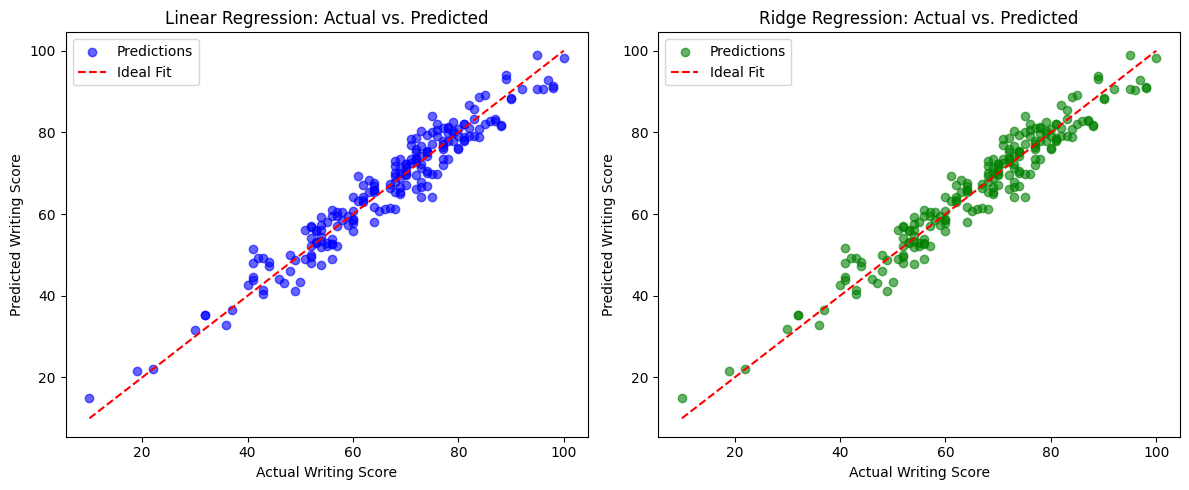

In [38]:
# Create side-by-side subplots for comparison.
plt.figure(figsize=(12, 5))

# Plot for Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', label='Ideal Fit')
plt.title("Linear Regression: Actual vs. Predicted")
plt.xlabel("Actual Writing Score")
plt.ylabel("Predicted Writing Score")
plt.legend()

# Plot for Ridge Regression
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_ridge, color='green', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', label='Ideal Fit')
plt.title("Ridge Regression: Actual vs. Predicted")
plt.xlabel("Actual Writing Score")
plt.ylabel("Predicted Writing Score")
plt.legend()

plt.tight_layout()
plt.show()
